# Creating multi-class classification data

X_blob: (tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]), tensor([3, 2, 2, 1, 1]))


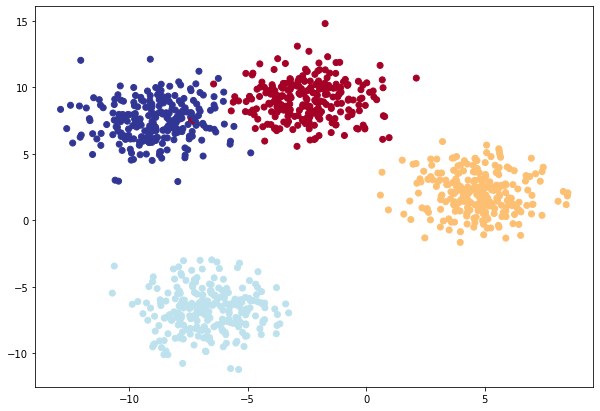

In [1]:
# importing dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# setting hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# creating multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES, # X features
                            centers=NUM_CLASSES, # y labels
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(f"X_blob: {X_blob[:5], y_blob[:5]}")

# split data into tranining and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                      y_blob,
                                                                      test_size=0.2,
                                                                      random_state=RANDOM_SEED)

# plot the data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [2]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): number of input features to model
            output features (int): number of output features to model
            hidden units (int): number of gidden units between layers
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [4]:
# creating a loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

In [5]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.0868, -1.2237,  0.4338,  0.8633],
        [-1.9963,  1.0073, -1.8601,  1.2271],
        [ 1.5143,  2.4894, -0.1824, -1.3256],
        [ 0.7414,  1.8290, -0.4123, -0.6400],
        [-1.5581,  1.1863, -1.6481,  0.9106]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [6]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.2068, -1.1063,  0.1928,  0.9875],
        [-1.9225,  2.5004, -2.4351,  0.6325],
        [ 1.4664,  1.8665,  0.0463, -1.0677],
        [ 0.4257, -0.8612,  0.5042,  0.5357],
        [-1.9025,  0.3109, -1.5080,  1.4312]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1613, 0.0656, 0.2406, 0.5325],
        [0.0102, 0.8521, 0.0061, 0.1316],
        [0.3555, 0.5304, 0.0859, 0.0282],
        [0.2879, 0.0795, 0.3114, 0.3213],
        [0.0252, 0.2306, 0.0374, 0.7068]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [8]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1613, 0.0656, 0.2406, 0.5325], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


In [9]:
# fit the model
torch.manual_seed(42)

# setting the number of epochs
epochs = 100

# putting the data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc


for epoch in range(epochs):
    # training
    model_4.train()

    # 1. Forwards pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    # # go from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. calculate the loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true = y_blob_train,
                      y_pred = y_pred)
    
    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # testing
    model_4.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_pred)
        
    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 2.90572, Acc: 0.00% | Test Loss: 1.17472, Test Acc: 25.50%
Epoch: 10 | Loss: 0.52125, Acc: 75.50% | Test Loss: 0.39081, Test Acc: 81.50%
Epoch: 20 | Loss: 0.12723, Acc: 99.12% | Test Loss: 0.11734, Test Acc: 99.50%
Epoch: 30 | Loss: 0.07908, Acc: 99.12% | Test Loss: 0.07150, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05982, Acc: 99.12% | Test Loss: 0.05243, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04985, Acc: 99.12% | Test Loss: 0.04228, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04388, Acc: 99.12% | Test Loss: 0.03607, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03995, Acc: 99.12% | Test Loss: 0.03192, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03719, Acc: 99.12% | Test Loss: 0.02895, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03517, Acc: 99.12% | Test Loss: 0.02674, Test Acc: 99.50%


In [10]:
# make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# view the first 10 preds
y_logits[:10]

tensor([[  5.8642,  11.1277, -10.9448,  -6.9679],
        [  1.2267, -13.4646,  -0.6105,   6.5996],
        [ -8.8506, -13.3403,  17.4751,   9.3340],
        [  2.9061,   8.4377,  -5.4136,  -4.8038],
        [  7.6462,   2.8536, -13.4697,  -3.3307],
        [  1.0673, -16.7369,  -0.0571,   8.2779],
        [ -8.4647,  -9.8342,  16.4962,   7.4761],
        [  5.7757,  -1.4312,  -9.7610,  -0.6719],
        [-10.0881, -19.0874,  20.1664,  12.5473],
        [  6.3434,   0.1526, -10.9097,  -1.6203]], device='cuda:0')

In [11]:
# turn predicted logits into prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)  

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


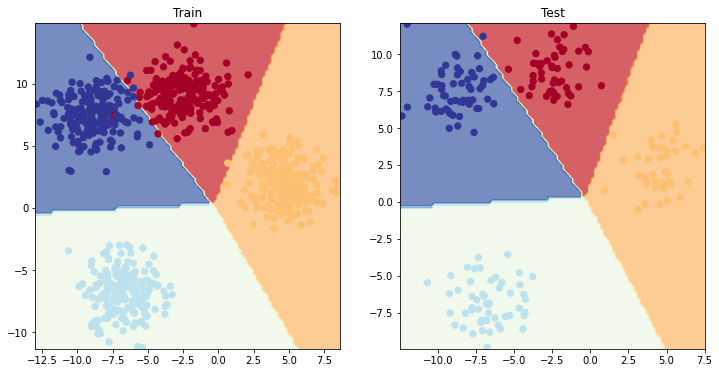

In [12]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [13]:

try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 9.2 MB/s eta 0:00:00a 0:00:01


tensor(0.9950, device='cuda:0')